# ChromaDB

## ChromaDB Overview

This tutorial will provide you with an introduction to ChromaDB, covering its fundamental and intermediate usage. We will explore topics such as constructing a ChromaDB, generating vectors, performing retrieval, updates, and deletions, as well as techniques for saving and loading data. Additionally, we will delve into a practical application of ChromaDB within a real-world project.

### What is ChromaDB?

ChromaDB is an open-source vector database designed to store vector embeddings to develop and build large language model (LLM) applications. ChromaDB is a powerful tool for building LLM applications. It is fast, efficient, and easy to use.

### Why ChromaDB

- **Speed and efficiency**: ChromaDB is built on top of Redis, a popular in-memory data store. This makes it very fast to store and query embeddings.
Ease of use: ChromaDB has a simple and intuitive API that makes it easy to get started.
- **Support for multiple embeddings formats**: ChromaDB supports a variety of embeddings formats, including Word2Vec, GloVe, and FastText.
- **Support for nearest neighbor search**: ChromaDB can be used to find the nearest neighbors of a given embedding. This is useful for applications such as semantic search and question answering.
- **Support for incremental updates**: ChromaDB can be updated incrementally, which makes it ideal for applications that need to be updated frequently.
- **Support for replication**: ChromaDB can be replicated to multiple servers, which provides high availability and fault tolerance.
- **Support hybrid cloud**: ChromaDB can be used both locally and in the cloud.

### Language Support

| Language     | In-Memory | Client & Server |
|--------------|:---------:|:---------------:|
| Python       | ✔       | ✔             |
| Javascript   | -        | ✔              |
| Ruby         | -        | from @mariochavez |
| C#           | -        | from Microsoft (coming soon) |
| Other?       | ?        | ?              |


## Environment setting

In [ ]:
%%capture
%pip install chromadb
%pip install datasets
%pip install sentence-transformers
%pip install openai
%pip install tiktoken

In [ ]:
import chromadb
import datasets
import transformers
import openai

print("chromadb version: ", chromadb.__version__)
print("datasets version: ", datasets.__version__)
print("transformers version: ", transformers.__version__)
print("openai version: ", openai.__version__)

chromadb version:  0.4.6
datasets version:  2.14.4
transformers version:  4.31.0
openai version:  0.27.8


In [ ]:
import json
import numpy as np
import pandas as pd
import pprint

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

We will use **unstructured-data-multilingual dataset**, A collection of multilingual review, image and sentiments dataset.

- language: ['en', 'ja', 'th']

- https://huggingface.co/datasets/jingwora/unstructured-data-multilingual

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("jingwora/unstructured-data-multilingual")

# Select split
dataset = dataset["en"]

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating en split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating ja split:   0%|          | 0/24 [00:00<?, ? examples/s]

Generating th split:   0%|          | 0/24 [00:00<?, ? examples/s]

Dataset({
    features: ['language', 'id', 'product_id', 'category', 'sub_category', 'product_name', 'product_detail', 'image_files', 'review', 'star', 'sentiment'],
    num_rows: 24
})

In [ ]:
# Convert dataset to Pandas DataFrame

df = pd.DataFrame(dataset)

In [ ]:
# Adding a category_label sentiment_label column
df['category_label'] = df['category'].map({'Electronics': 0, 'Health and Beauty': 1})
df['sentiment_label'] = df['sentiment'].map({'positive': 0, 'neutral': 1, 'negative': 2})
df['product_name_label'] = df['product_name'].map({'Smart watch': 0, 'Wall Lamps': 1, 'Supplements': 2, 'Sunblock': 3})

In [ ]:
# All text column for embedding

df['text'] = df['category'] + ", " + df['sub_category'] + ", " + df['product_detail'] + ", " + df['review'] + ", " + df['sentiment']+ ", " + df['star']


In [ ]:
df.head(2)

,language,id,product_id,category,sub_category,product_name,product_detail,image_files,review,star,sentiment,category_label,sentiment_label,product_name_label,text
0,en,en-001,en-001,Electronics,Wearable devices,Smart watch,[en-001] Smartwatch for Android and iOS Phones...,"en-001-01.jpg, en-001-02.jpg",I got much more than I expected for $43. The h...,4-5,positive,0,0,0,"Electronics, Wearable devices, [en-001] Smartw..."
1,en,en-002,en-001,Electronics,Wearable devices,Smart watch,[en-001] Smartwatch for Android and iOS Phones...,"en-001-01.jpg, en-001-02.jpg",This was a gift for me. I am very happy with t...,4-5,positive,0,0,0,"Electronics, Wearable devices, [en-001] Smartw..."


In [ ]:
# Check label

display(df.groupby(['sentiment_label']).size())

sentiment_label
0    8
1    8
2    8
dtype: int64

## Embeddings

- Chroma will use sentence transfomer as a default.

https://huggingface.co/intfloat/multilingual-e5-large

https://huggingface.co/spaces/mteb/leaderboard

In [ ]:
from sentence_transformers import SentenceTransformer

# Specify the cache directory path
cache_dir = "/content/drive/MyDrive/models/intfloat_multilingual-e5-large/"

# Load the SentenceTransformer model
model = SentenceTransformer("intfloat/multilingual-e5-large", cache_folder=cache_dir)

In [ ]:
# embeddings

# Function to generate embeddings
def generate_embeddings(text):
    embeddings = model.encode(text)
    return embeddings.tolist()

df['embeddings'] = df['text'].apply(generate_embeddings)

# Check embedding
sample_embeddings = df["embeddings"][0]
print(type(sample_embeddings))
embeddings_array = np.array(df['embeddings'].tolist())

print("embeddings length: ", len(sample_embeddings))
print("embeddings max:", embeddings_array.max())
print("embeddings min:", embeddings_array.min())

<class 'list'>
embeddings length:  1024
embeddings max: 0.19590376317501068
embeddings min: -0.12061437964439392


In [ ]:
import numpy as np
from ast import literal_eval
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

def get_scatter_plot(input_df, method="TSNE", label_col="label"):

    df = input_df.copy()

    # Create numpy array
    matrix = np.array(df["embeddings"].apply(lambda x: x).tolist())

    if method == "TSNE":
        # Create a t-SNE model and transform the data
        tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
        vis_dims = tsne.fit_transform(matrix)

    elif method == "PCA":
        pca = PCA(n_components=2)
        pca.fit(matrix)
        vis_dims = pca.transform(matrix)
    else:
        print("please specify method as 'TSNE' or 'PCA'")

    # Plot
    x = [x for x, y in vis_dims]
    y = [y for x, y in vis_dims]
    color_indices = df[label_col].values

    unique_labels = np.unique(color_indices)
    num_labels = len(unique_labels)

    # Generate a colormap with the appropriate number of colors
    colormap = matplotlib.colormaps['tab10']

    plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.5)
    for idx, label in enumerate(unique_labels):
        avg_x = np.mean(np.array(x)[df[label_col] == label])
        avg_y = np.mean(np.array(y)[df[label_col] == label])
        color = colormap(idx % num_labels)
        plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

    plt.title(f"Scatter Plot: {method} | {label_col}")

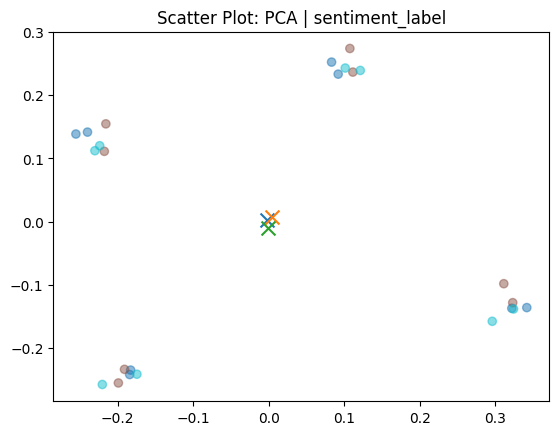

In [ ]:
# Plot data

get_scatter_plot(df, method="PCA", label_col="sentiment_label")

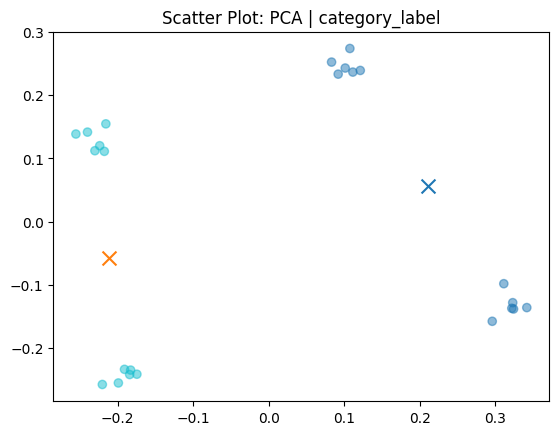

In [ ]:
# Plot data

get_scatter_plot(df, method="PCA", label_col="category_label")

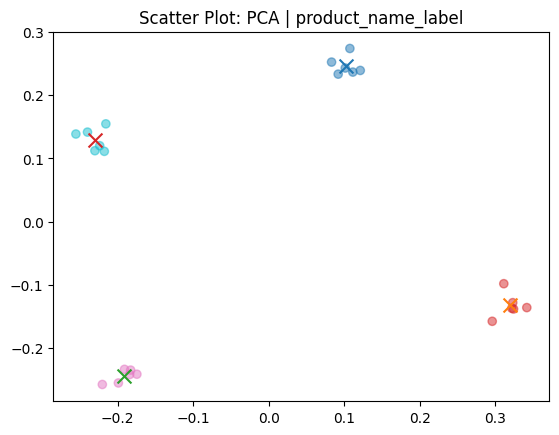

In [ ]:
# Plot data

get_scatter_plot(df, method="PCA", label_col="product_name_label")

# ChromaDB functions

## Methods on Client

### EphemeralClient
- You can configure Chroma to save and load from your local machine. Data will be persisted automatically and loaded on start (if it exists).

- Create chroma.sqlite3

In [ ]:
import chromadb
from chromadb.config import Settings

chroma_client = chromadb.EphemeralClient()
chroma_client = chromadb.PersistentClient(path="/content/drive/MyDrive/share_KM/VectorDB/chromadb")

### create_collection

- Collections are where you'll store your embeddings, documents, and any additional metadata.
- ```create_collection```

In [ ]:
review_cl = chroma_client.create_collection(name="review")

In [ ]:
test_cl = chroma_client.create_collection(name="test")

In [ ]:
type(review_cl)

chromadb.api.models.Collection.Collection

### heartbeat
- returns a nanosecond heartbeat. Useful for making sure the client remains connected.

In [ ]:
chroma_client.heartbeat()

1692368007886895514

 ### reset
 - Empties and completely resets the database.
 - ⚠️ This is destructive and not reversible.

In [ ]:
# chroma_client.reset()

### get_collection
- Get a collection object from an existing collection
- ```name```: collection name

In [ ]:
review_cl = chroma_client.get_collection(name="review")

print(type(review_cl))

<class 'chromadb.api.models.Collection.Collection'>


### get_or_create_collection

- Get a collection object from an existing collection, by name. If it doesn't exist, create it.

In [ ]:
review_cl = chroma_client.get_or_create_collection(name="review")

print(type(review_cl))

<class 'chromadb.api.models.Collection.Collection'>


### list_collections
- to list all corrections.

In [ ]:
collections = chroma_client.list_collections()

for collection in collections:
  print(collection.name)

review
test
classification


### delete_collection
- Delete a collection and all associated embeddings, documents, and metadata. ⚠️ This is destructive and not reversible

In [ ]:
chroma_client.delete_collection(name="test")

## Methods on Collection

### add

- Add text documents to the collection
- parameters:
  - ```documents```: A list of documents.
  - ```embedding```: An optional list of embeddings for the documents.
  - ```ids```: An optional list of IDs for the documents.
  - ```collection_name```: The name of the collection to create.
  - ```persist_directory```: The directory to store the collection data.
  - ```client```: An optional Client object.

In [ ]:
# Add documents, embeddings and metadatas

review_cl.add(
    documents=df["review"].tolist(),
    embeddings=df["embeddings"].tolist(),
    metadatas=[
        {
            "language": language,
            "product_id": product_id,
            "category": category,
            "sub_category": sub_category,
            "product_name": product_name,
            "image_files": image_files,
            "sentiment": sentiment
        }
        for language, product_id, category, sub_category, product_name, image_files, sentiment
        in zip(
            df["language"].tolist(),
            df["product_id"].tolist(),
            df["category"].tolist(),
            df["sub_category"].tolist(),
            df["product_name"].tolist(),
            df["image_files"].tolist(),
            df["sentiment"].tolist()
        )
    ],
    ids=df["id"].tolist()
)

### peek

- returns a list of the first 5 items in the collection unless specify.

In [ ]:
print(review_cl.peek(1))

{'ids': ['en-001'], 'embeddings': [[0.021863875910639763, -0.0120804812759161, -0.05256242677569389, -0.04863062873482704, 0.024465247988700867, -0.03576693311333656, -0.02253131940960884, 0.06737581640481949, 0.047938354313373566, -0.03940020874142647, 0.03816855326294899, 0.006266389973461628, -0.04329701140522957, -0.029355153441429138, -0.03670046478509903, -0.009801299311220646, -0.03310786187648773, 0.020813459530472755, 0.014547375030815601, -0.03905715048313141, 0.04723501205444336, -0.0302769485861063, -0.039253637194633484, -0.026194004341959953, -0.013484600931406021, -0.017938677221536636, -0.025871267542243004, -0.04433213919401169, 0.016651613637804985, -0.02965617924928665, -0.021656086668372154, 0.006256919354200363, -0.015192224644124508, -0.04714614525437355, -0.05010604113340378, 0.012543193064630032, 0.01598731055855751, 0.034970723092556, -0.03953193500638008, 0.0060806721448898315, 0.003679336281493306, 0.053915590047836304, -0.005187002941966057, -0.0183136332780

### count
- returns the number of items in the collection

In [ ]:
review_cl.count()

24

### modify
- Rename the collection

In [ ]:
review_cl.modify(name="review")

### get
- Parameters:
  - ```ids```: get item by ids
  - ```where```: meta data condition

In [ ]:
# get ids

results = review_cl.get(
    ids=["en-001"],
)

print(type(results))
print(json.dumps(results, indent=4))

<class 'dict'>
{
    "ids": [
        "en-001"
    ],
    "embeddings": null,
    "metadatas": [
        {
            "category": "Electronics",
            "image_files": "en-001-01.jpg, en-001-02.jpg",
            "language": "en",
            "product_id": "en-001",
            "product_name": "Smart watch",
            "sentiment": "positive",
            "sub_category": "Wearable devices"
        }
    ],
    "documents": [
        "I got much more than I expected for $43. The health monitoring alone is worth it, but the sports functions, the sleep data, and the ability to combine the data with google Fit, has been invaluable. I would consider this an excellent starter watch, except I have no plans to get a better one."
    ]
}


In [ ]:
# get ids + where

results = review_cl.get(
    ids=["en-001", "en-002", "en-003"],
    where={"sentiment": "positive"}
)

print(json.dumps(results, indent=4))

{
    "ids": [
        "en-001",
        "en-002"
    ],
    "embeddings": null,
    "metadatas": [
        {
            "category": "Electronics",
            "image_files": "en-001-01.jpg, en-001-02.jpg",
            "language": "en",
            "product_id": "en-001",
            "product_name": "Smart watch",
            "sentiment": "positive",
            "sub_category": "Wearable devices"
        },
        {
            "category": "Electronics",
            "image_files": "en-001-01.jpg, en-001-02.jpg",
            "language": "en",
            "product_id": "en-001",
            "product_name": "Smart watch",
            "sentiment": "positive",
            "sub_category": "Wearable devices"
        }
    ],
    "documents": [
        "I got much more than I expected for $43. The health monitoring alone is worth it, but the sports functions, the sleep data, and the ability to combine the data with google Fit, has been invaluable. I would consider this an excellent starter w

### query

- Query the collection
- Parameters:
  - ```query_texts```: input text (defualt embeddings)
  - ```generate_embeddings```: input embedding
  - ```n_results```: number of returned ids

In [ ]:
# query

query_embeddings = generate_embeddings("Smart watch")
results = review_cl.query(query_embeddings=query_embeddings,
                          n_results=2,
                          )

print(json.dumps(results, indent=4))

{
    "ids": [
        [
            "en-002",
            "en-001"
        ]
    ],
    "distances": [
        [
            0.3552019421462704,
            0.3670178482029353
        ]
    ],
    "metadatas": [
        [
            {
                "category": "Electronics",
                "image_files": "en-001-01.jpg, en-001-02.jpg",
                "language": "en",
                "product_id": "en-001",
                "product_name": "Smart watch",
                "sentiment": "positive",
                "sub_category": "Wearable devices"
            },
            {
                "category": "Electronics",
                "image_files": "en-001-01.jpg, en-001-02.jpg",
                "language": "en",
                "product_id": "en-001",
                "product_name": "Smart watch",
                "sentiment": "positive",
                "sub_category": "Wearable devices"
            }
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            

In [ ]:
# query + where

query_embeddings = generate_embeddings("The worst and terrify review")
results = review_cl.query(query_embeddings=query_embeddings,
                          where={"sentiment": "negative"},
                          n_results=1,
                          )
print(json.dumps(results, indent=4))

{
    "ids": [
        [
            "en-017"
        ]
    ],
    "distances": [
        [
            0.39955426555799967
        ]
    ],
    "metadatas": [
        [
            {
                "category": "Health and Beauty",
                "image_files": "en-003-01.jpg, en-003-02.jpg",
                "language": "en",
                "product_id": "en-003",
                "product_name": "Supplements",
                "sentiment": "negative",
                "sub_category": "Health"
            }
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "I experienced with this product was horrible. The firts day wasnt as bad as the the second. The first day i took it as instructed in the morning and around the afternoon i felt very fatigued and nauseous. I didnt give a thought and ignored it. Second day I took it in the morning also but oh gosh, by lunch time i felt extremely fatigued , nauseous and dizzy."
        ]
    ]
}


In [ ]:
# query + where + where_document

results = review_cl.query(query_embeddings=query_embeddings,
                          where={"sentiment": "negative"},
                          where_document={"$contains":"lid"},
                          n_results=1,
                          )
print(json.dumps(results, indent=4))

{
    "ids": [
        [
            "en-024"
        ]
    ],
    "distances": [
        [
            0.45791309157891946
        ]
    ],
    "metadatas": [
        [
            {
                "category": "Health and Beauty",
                "image_files": "en-004-01.jpg, en-004-02.jpg",
                "language": "en",
                "product_id": "en-004",
                "product_name": "Sunblock",
                "sentiment": "negative",
                "sub_category": "Beauty"
            }
        ]
    ],
    "embeddings": null,
    "documents": [
        [
            "Just disappointed...received the sunscreen and it appears like someone used this before. The lid was messy but not in box."
        ]
    ]
}


### delete

- delete documents from collection

In [ ]:
review_cl.delete(ids=["en-020"])

In [ ]:
review_cl.get(
    ids=["en-020"],
)

{'ids': [], 'embeddings': None, 'metadatas': [], 'documents': []}

### update

- update document

In [ ]:
review_cl.get(
    ids=["en-021"],
)

{'ids': ['en-021'],
 'embeddings': None,
 'metadatas': [{'category': 'Health and Beauty',
   'image_files': 'en-004-01.jpg, en-004-02.jpg',
   'language': 'en',
   'product_id': 'en-004',
   'product_name': 'Sunblock',
   'sentiment': 'neutral',
   'sub_category': 'Beauty'}],
 'documents': ['Guys this is probably good for body use, but please learn from me I tried this in my forehead only and this gave me a blazing red rash and swollen eyes!! It was the only thing I used to test out. ']}

In [ ]:
review_cl.update(
    ids=["en-021"],
    metadatas=[{"product_name": "Sunblock_new"}],
)

In [ ]:
review_cl.get(
    ids=["en-021"],
)

{'ids': ['en-021'],
 'embeddings': None,
 'metadatas': [{'category': 'Health and Beauty',
   'image_files': 'en-004-01.jpg, en-004-02.jpg',
   'language': 'en',
   'product_id': 'en-004',
   'product_name': 'Sunblock_new',
   'sentiment': 'neutral',
   'sub_category': 'Beauty'}],
 'documents': ['Guys this is probably good for body use, but please learn from me I tried this in my forehead only and this gave me a blazing red rash and swollen eyes!! It was the only thing I used to test out. ']}

### upsert

- upsert items. new items will be added, existing items will be updated.

In [ ]:
# upsert items

review_cl.upsert(
    documents=df["review"].tolist(),
    embeddings=df["embeddings"].tolist(),
    metadatas=[
        {
            "language": language,
            "product_id": product_id,
            "category": category,
            "sub_category": sub_category,
            "product_name": product_name,
            "image_files": image_files,
            "sentiment": sentiment
        }
        for language, product_id, category, sub_category, product_name, image_files, sentiment
        in zip(
            df["language"].tolist(),
            df["product_id"].tolist(),
            df["category"].tolist(),
            df["sub_category"].tolist(),
            df["product_name"].tolist(),
            df["image_files"].tolist(),
            df["sentiment"].tolist()
        )
    ],
    ids=df["id"].tolist()
)

## embedding
- By default, Chroma uses the Sentence Transformers ```all-MiniLM-L6-v2``` model to create embeddings.
- https://www.sbert.net/docs/pretrained_models.html

### DefaultEmbeddingFunction

In [ ]:
from chromadb.utils import embedding_functions

default_ef = embedding_functions.DefaultEmbeddingFunction()

default_ef

### SentenceTransformerEmbeddingFunction

In [ ]:
# Load the SentenceTransformer
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="intfloat/multilingual-e5-large")

sentence_transformer_ef

### OpenAI

In [ ]:
import os
import getpass
import openai

APIKEY = getpass.getpass("APIKEY: ")
os.environ["OPENAI_API_KEY"] = APIKEY
openai.api_key = os.environ["OPENAI_API_KEY"]

APIKEY: ··········


In [ ]:
from chromadb.utils import embedding_functions

def text_embedding(text):
    response = openai.Embedding.create(model="text-embedding-ada-002", input=text)
    return response["data"][0]["embedding"]

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.environ["OPENAI_API_KEY"],
                model_name="text-embedding-ada-002"
            )

In [ ]:
embeddings = text_embedding("test")
print(embeddings)

[-0.0017262666951864958, -0.013922297395765781, 0.0016728137852624059, -0.018408838659524918, -0.0071258884854614735, 0.018563061952590942, -0.00954090990126133, -0.029190557077527046, -0.006235590670257807, -0.01467940118163824, 0.011791190132498741, 0.007153929676860571, 0.0013932812726125121, -0.01178418006747961, -0.007090837694704533, 0.01302498858422041, 0.046940434724092484, 0.0009928224608302116, 0.0170208141207695, -0.02868582122027874, 0.010585431940853596, 0.007311659399420023, -0.003193155163899064, 0.0016386389033868909, -0.03011590614914894, -0.014791564084589481, 0.0017744619399309158, -0.03701396286487579, -0.003161609172821045, 0.0028969733975827694, 0.018885532394051552, -0.028882106766104698, -0.0267089381814003, -0.029807455837726593, -0.023315992206335068, -0.008412264287471771, -0.00388366193510592, -0.013943327590823174, 0.017918122932314873, -7.968648424139246e-05, 0.01041017659008503, 0.01330539770424366, 0.005548588931560516, -0.014623318798840046, -0.00316686

In [ ]:
# set embedding_function
review_cl = chroma_client.get_collection(name="review", embedding_function=openai_ef)

review_cl

Collection(name=review)

References:

- Chroma docs: https://docs.trychroma.com/
- api-reference: https://docs.trychroma.com/api-reference
- datasets: https://huggingface.co/datasets/jingwora/unstructured-data-multilingual
